# Obtain necessary imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import os
import sys

from IPython.display import display, HTML
from numpy import NaN, Inf, arange, isscalar, asarray, array

# Create function for peak detection

In [2]:
def peakdet(v, delta, x = None):
    """
    Converted from MATLAB script at http://billauer.co.il/peakdet.html
    
    Returns two arrays
    
    function [maxtab, mintab]=peakdet(v, delta, x)
    %PEAKDET Detect peaks in a vector
    %        [MAXTAB, MINTAB] = PEAKDET(V, DELTA) finds the local
    %        maxima and minima ("peaks") in the vector V.
    %        MAXTAB and MINTAB consists of two columns. Column 1
    %        contains indices in V, and column 2 the found values.
    %      
    %        With [MAXTAB, MINTAB] = PEAKDET(V, DELTA, X) the indices
    %        in MAXTAB and MINTAB are replaced with the corresponding
    %        X-values.
    %
    %        A point is considered a maximum peak if it has the maximal
    %        value, and was preceded (to the left) by a value lower by
    %        DELTA.
    
    % Eli Billauer, 3.4.05 (Explicitly not copyrighted).
    % This function is released to the public domain; Any use is allowed.
    
    """
    maxtab = []
    mintab = []
       
    if x is None:
        x = arange(len(v))
    
    v = asarray(v)
    
    if len(v) != len(x):
        sys.exit('Input vectors v and x must have same length')
    
    if not isscalar(delta):
        sys.exit('Input argument delta must be a scalar')
    
    if delta <= 0:
        sys.exit('Input argument delta must be positive')
    
    mn, mx = Inf, -Inf
    mnpos, mxpos = NaN, NaN
    
    lookformax = True
    
    for i in arange(len(v)):
        this = v[i]
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]
        
        if lookformax:
            if this < mx-delta:
                maxtab.append((mxpos, mx))
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn+delta:
                mintab.append((mnpos, mn))
                mx = this
                mxpos = x[i]
                lookformax = True

    return array(maxtab), array(mintab)

# Single cell simulation for Panel F

## Establish parameters

In [3]:
dt=.2
T=int(7000/dt)

V_PLC=1.2
K_PLC=.2
K_5=0.66
K_3=0.4
k_3=0.0

k_1=1.11
k_a=0.08
k_p=0.13
k_2=0.0203
V_SERCA=0.9
K_SERCA=0.1
c_tot=2
beta=.185
tau=12.5
k_i=0.4
tau_p=1

Vpm=0.0
Kpm=0.01
phi=0
v0=0.0008
epsilon=.0
pow_cal=2
j_in=0

v8=.00
kg=0
alpha=0.0

tau_new_max=1000
kk_tau_new_vector=[.5,.75,1]
vplc_vector=np.arange(0.75,0.85,.001)

## Run the single cell simulation

In [4]:
X=np.zeros((4,T,len(vplc_vector)))
X[0,0,:]=.05
X[1,0,:]=1
X[2,0,:]=(c_tot-.05)/beta
X[3,0,:]=0.5


for j in range(len(vplc_vector)):
    for i in range(1,T):
        c_old=X[0,i-1,j]
        p_old=X[1,i-1,j]
        s_old=X[2,i-1,j]
        r_old=X[3,i-1,j]
        kk_tau_new=1
        V_PLC= vplc_vector[j]

        c_new=c_old+dt*((k_1*(r_old*c_old*p_old/(k_a+c_old)/(k_p+p_old))**3+k_2)*(s_old-c_old)-V_SERCA*c_old**2/(c_old**2+K_SERCA**2)+epsilon*(v0+phi*V_PLC/(k_3+K_5)-Vpm*c_old**2/(c_old**2+Kpm**2)) )
        p_new=p_old+dt*tau_p*(V_PLC*c_old**pow_cal/(c_old**pow_cal+K_PLC**pow_cal)-K_5*p_old-k_3*p_old*c_old**2/(c_old**2+ K_3**2))
        s_new=s_old+dt*(1.0/beta)*( V_SERCA*c_old**2/(c_old**2+ K_SERCA**2)-(k_1*(r_old*c_old*p_old/(k_a+c_old)/(k_p+p_old))**3+k_2 )*(s_old-c_old))
    
        tau_new=tau_new_max*(kk_tau_new**4)/(c_old**4+kk_tau_new**4)
        r_new=r_old+dt*(1.0/tau_new)*(1-r_old*(k_i+c_old)/k_i)

        X[0,i,j]=c_new
        X[1,i,j]=p_new
        X[2,i,j]=s_new
        X[3,i,j]=r_new

## Calculate frequencies

In [5]:
freq = np.zeros((len(vplc_vector),1))
for j in range(len(vplc_vector)):
    maxtab, mintab = peakdet(X[0,:,j],.05)
    
    if len(maxtab)>1:
        indices=np.sort(maxtab[:,0])
        period=(indices[1]-indices[0])*dt
        freq[j,0]=2*np.pi*1000.0/period

## Create plot

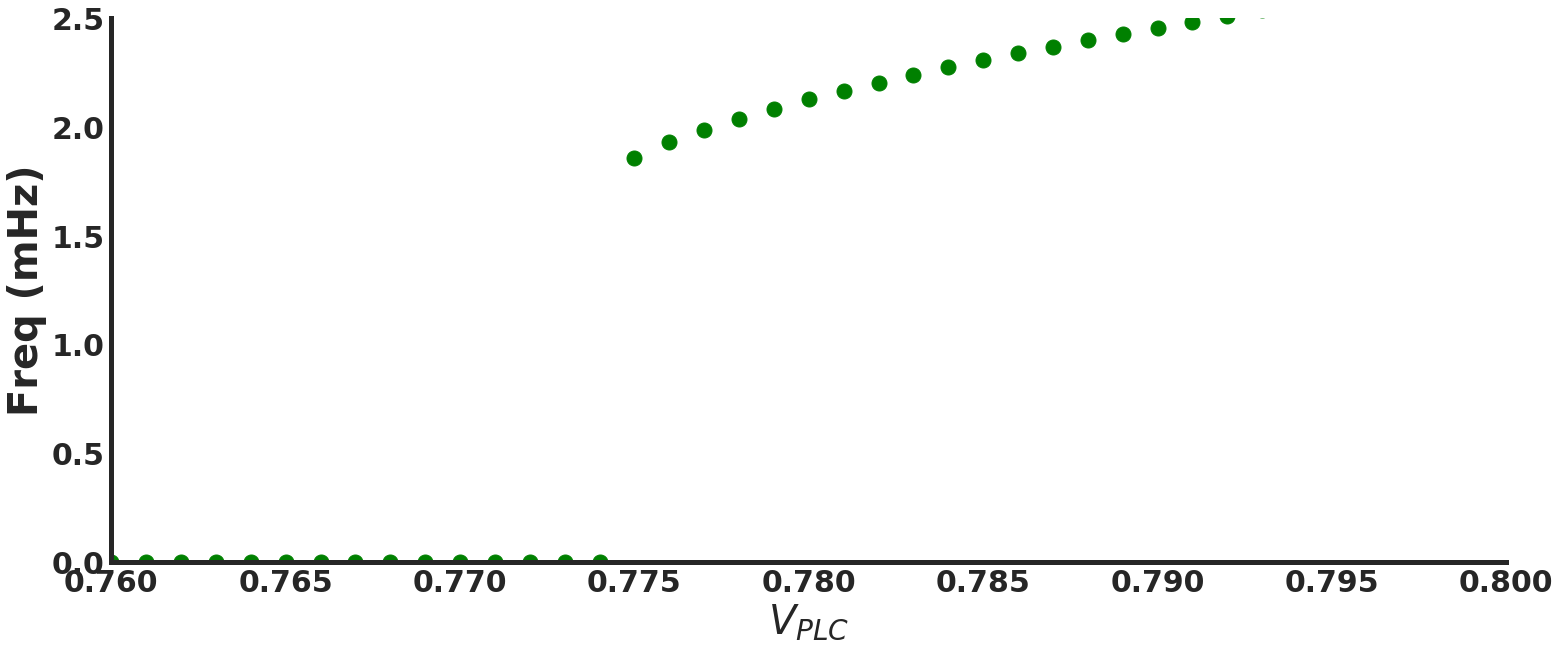

In [6]:
with sns.axes_style("white"):
    fig=plt.figure(figsize=(25,10))
    ax = plt.axes()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    plt.yticks(fontsize=30,fontweight='bold')
    plt.xticks(fontsize=30,fontweight='bold')
    plt.plot(vplc_vector,freq ,'go',markersize=15,linewidth=12 )
    
    plt.xlabel(r'$V_{PLC}$',fontsize=40,fontweight='bold')
    ax.set_ylabel('Freq (mHz)',fontsize=40,fontweight='bold')
    plt.xlim(0.76, 0.8)
    plt.ylim(0, 2.5)

saveFolderName = './simulationResults/Figure_2' # The folder where simulation results are to be saved for this notebook
if not os.path.exists(saveFolderName): # Create the folder if it does not yet exist
    os.makedirs(saveFolderName)
    
fig.savefig(saveFolderName + '/Panel_F_Freq.pdf',transparent=True) 

# Single cell simulation for Panel G

## Establish parameters

In [7]:
dt=.2
T=int(7000/dt)#int(3600/dt)

V_PLC=1.2
K_PLC=.2
K_5=0.66
K_3=0.4
k_3=0.0

k_1=1.11
k_a=0.08
k_p=0.13
k_2=0.0203
V_SERCA=0.9
K_SERCA=0.1
c_tot=2
beta=.185
tau=12.5
k_i=0.4
tau_p=1

Vpm=0.0
Kpm=0.01
phi=0
v0=0.0008
epsilon=.0
pow_cal=2
j_in=0

v8=.00
kg=0
alpha=0.0

tau_new_max=800
kk_tau_new_vector=np.arange(0.7,1.7,.025)#[0.5,1,1.5]#
tau_new_max_profile=np.linspace(1000,830,len(kk_tau_new_vector))#[1000,875,830]#

X=np.zeros((4,T,len(kk_tau_new_vector)))
X[0,0,:]=.05
X[1,0,:]=1
X[2,0,:]=(c_tot-.05)/beta
X[3,0,:]=0.5

## Run the single cell simulation

In [8]:
for j in range(len(kk_tau_new_vector)):
    for i in range(1,T):
        c_old=X[0,i-1,j]
        p_old=X[1,i-1,j]
        s_old=X[2,i-1,j]
        r_old=X[3,i-1,j]
        kk_tau_new=kk_tau_new_vector[j]
        tau_new_max= tau_new_max_profile[j]

        c_new=c_old+dt*((k_1*(r_old*c_old*p_old/(k_a+c_old)/(k_p+p_old))**3 +k_2 )*(s_old-c_old) -V_SERCA*c_old**2/(c_old**2+ K_SERCA**2) +epsilon*(v0+phi*V_PLC/(k_3+K_5) -Vpm*c_old**2/(c_old**2+ Kpm**2)) )
        p_new=p_old+dt*tau_p*(V_PLC*c_old**pow_cal/(c_old**pow_cal+ K_PLC**pow_cal)  -  K_5*p_old -k_3*p_old*c_old**2/(c_old**2+ K_3**2)  )
        s_new=s_old+dt*(1.0/beta)*( V_SERCA*c_old**2/(c_old**2+ K_SERCA**2)- (k_1*(r_old*c_old*p_old/(k_a+c_old)/(k_p+p_old))**3 +k_2 )*(s_old-c_old) )
        tau_new= tau_new_max * (kk_tau_new**4)/(c_old**4+ kk_tau_new**4)
        r_new=r_old+dt*(1.0/tau_new)*( 1-r_old*(k_i+c_old)/k_i)

        X[0,i,j]=c_new
        X[1,i,j]=p_new
        X[2,i,j]=s_new
        X[3,i,j]=r_new

## Calculate WHM

In [9]:
whm = np.zeros((len(kk_tau_new_vector),1))
for j in range(len(kk_tau_new_vector)):
    maxtab, mintab = peakdet(X[0,:,j],.05)
    
    if len(maxtab)>1:
        deducted= X[0,:,j]-(X[0,:,j].max()/2.0)
        zero_crossings = np.where(np.diff(np.sign(deducted)))[0]
        whm[j,0]=(zero_crossings[3]-zero_crossings[2])*dt

## Create plot

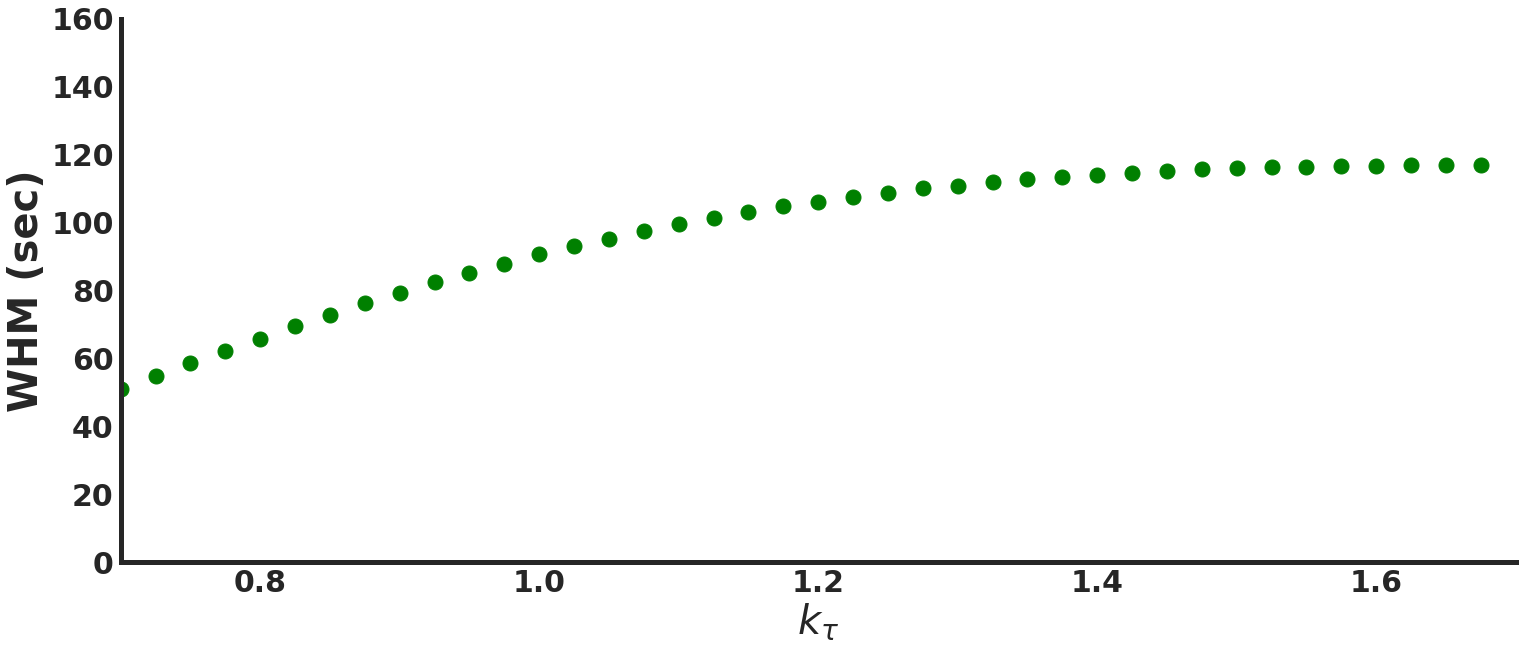

In [10]:
with sns.axes_style("white"):
    fig=plt.figure(figsize=(25,10))
    ax = plt.axes()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(5)
    ax.spines['bottom'].set_linewidth(5)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    plt.yticks(fontsize=30,fontweight='bold')
    plt.xticks(fontsize=30,fontweight='bold')
    plt.plot(kk_tau_new_vector,whm ,'go',markersize=15,linewidth=12 )

    plt.xlabel(r'$k_{\tau}$',fontsize=40,fontweight='bold')
    ax.set_ylabel('WHM (sec)',fontsize=40,fontweight='bold')
    plt.xlim(0.7, 1.7)
    plt.ylim(0, 160)
    
fig.savefig(saveFolderName + '/Panel_G_WHM.pdf',transparent=True) 